## This notebook is for statistical analysis & plotting (class 03, 04, 05) 

In [1]:
#last update: 22-01-09 #used sort2

## 1. Import module, parameter file, and preprocessed file

In [2]:
MAC0_OR_LINUX1 = 0
SORT_VER = 'sort2'

In [3]:
#cd /Users/dlee/moving-bar

In [4]:
import sys
sys.path.append('../')

import numpy as np
import scipy.stats
import scipy.ndimage
import sklearn.linear_model
import json
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches
import pandas as pd
import sklearn.decomposition
import sklearn.cluster
import tqdm
import pickle
import copy

import pyret.stimulustools as st
import pyret.filtertools as ft
import pyret.spiketools as spk
import pyret.nonlinearities as nlt
import experiment as exp
import extract as ext
import utils
import stats
import analysis
from analysis import ts2st

%load_ext autoreload
%autoreload 2

In [5]:
def smooth(mat, s1=1, s2=1):
    return scipy.ndimage.gaussian_filter(mat, [s1, s2])
def smooth_1d(mat, s=1):
    return scipy.ndimage.gaussian_filter1d(mat, s)
def nn(mat, pad=0):
    temp_mat = copy.deepcopy(mat)
    temp_mat[np.isnan(temp_mat)] = pad
    return temp_mat

In [6]:
def tr(mat, pad='nan'):
    if pad == 'zero':
        mat_tr = np.stack([np.roll(np.pad(mat, ((0, 0), (70, 70)), mode='constant')[t, :], 64-t)[70:-70] for t in range(mat.shape[0])])
    else:
        mat_tr = np.stack([np.roll(np.pad(mat, ((0, 0), (70, 70)), mode='constant', constant_values=(np.nan, np.nan))[t, :], 64-t)[70:-70] for t in range(mat.shape[0])])
    return copy.deepcopy(mat_tr)

In [7]:
utils.set_plot_params()

In [8]:
if MAC0_OR_LINUX1 == 1:
    home_dir = '/home'
elif MAC0_OR_LINUX1 == 0:
    home_dir = '/Users'
proj_dir = home_dir + '/dlee/moving-bar/'
exp_list = ['17-10-18', '17-10-20', '17-10-26', '17-10-26-1', '17-10-27',
            '17-11-06', '17-11-07', '17-11-08', '17-11-14', '17-11-14-1',
            '17-11-29', '18-03-12', '18-03-22', '18-03-23', '18-03-24',
            '18-03-24-1', '18-03-27', '18-04-23']
N_expt = len(exp_list)
stim_sort_total_list = ['flash_1', 'rf_wn', 'mb_ns', 'mb_ad', 'mb_da', 
                        'mb_2ad', 'mb_4ad', 'mb_2da', 'mb_4da', 'rf_30m']
stim_notforsort_total_list = ['line', 'rf_5m', 'mb', 'flash_2']
c_idx = utils.color_index()

In [9]:
# confirm filename 

In [10]:
class_num_1 = 3 # "fastest" (biphasic, fast) or fast
class_num_2 = 4 # "fast" (monophasic, fast) or medium
class_num_3 = 5 # "medium" (medium) or slow

In [11]:
# Load pickled data
ex = pickle.load(open(proj_dir + 'data-figure/' + 'ex_210214.p', 'rb'))
df = pickle.load(open(proj_dir + 'data-figure/' + 'df_210214.p', 'rb'))
re1 = pickle.load(open(proj_dir + 'data-figure/' + 'bootstrap_c' + "{:02d}".format(class_num_1) + '.p', 'rb'))
re2 = pickle.load(open(proj_dir + 'data-figure/' + 'bootstrap_c' + "{:02d}".format(class_num_2) + '.p', 'rb'))
re3 = pickle.load(open(proj_dir + 'data-figure/' + 'bootstrap_c' + "{:02d}".format(class_num_3) + '.p', 'rb'))

In [12]:
N_g = df.shape[0]
N_i = df['exp_id'].max() + 1
N_g, N_i

(189, 18)

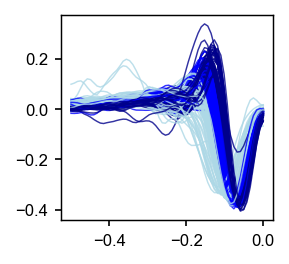

In [13]:
figure = plt.figure(figsize=(4, 4))
ax = plt.subplot(221)
for g in range(N_g):
    if df['g_classify_idx'][g] == 0:
        ax.plot(np.linspace(-0.5, 0, 60), ex.rf['g']['time'][g], linewidth=0.7, color='darkblue', alpha=0.8)
    if df['g_classify_idx'][g] == 4:
        ax.plot(np.linspace(-0.5, 0, 60), ex.rf['g']['time'][g], linewidth=0.7, color='blue', alpha=0.8)
    if df['g_classify_idx'][g] == 1:
        ax.plot(np.linspace(-0.5, 0, 60), ex.rf['g']['time'][g], linewidth=0.7, color='lightblue', alpha=0.8)

In [14]:
bar_st = st.downsample(ex.stim['mb'][0].astype('double').T, 2)[0].T
tbins = ex.tbins['mb_ad'][0] - ex.tbins['mb_ad'][0][64]# + ex.tbins['mb_ad'][0][1]/2
sbins = np.linspace(-127.5 * (100/17), 127.5 * (100/17), 128)

In [15]:
#del ex

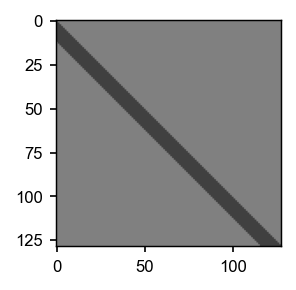

In [16]:
bar_st[bar_st == 63] = -0.5
bar_st[bar_st == 127] = 0
plt.imshow(bar_st, cmap='gray', vmin=-1, vmax=1)

In [17]:
df.head()

,exp_id,exp_date,exp_name,exp_version,sort_version_num,retina_idx,intracell_idx,g_cell_num,g_cell_id,flash_1,...,g_2px_binspace_idx_cen_i,i_mb_lin_st_cc_mean,i_mb_lin_line_cc_mean,g_mb_lin_cc_mean_lr,g_mb_lin_cc_mean_rl,g_mb_lin_cc_mean,g_mb_ln_cc_mean_lr,g_mb_ln_cc_mean_rl,g_mb_ln_cc_mean,i_mb_classify_idx
0,0,17-10-18,17-10-18,1,2,1,5,6,0,1,...,67,0.785154,0.685979,0.571053,0.518339,0.544696,0.684928,0.589939,0.637434,7
1,0,17-10-18,17-10-18,1,2,1,5,6,1,1,...,74,0.785154,0.685979,0.495465,0.442066,0.468766,0.563725,0.471638,0.517682,7
2,0,17-10-18,17-10-18,1,2,1,5,6,2,1,...,71,0.785154,0.685979,0.513415,0.493600,0.503507,0.565402,0.534236,0.549819,7
3,0,17-10-18,17-10-18,1,2,1,5,6,3,1,...,61,0.785154,0.685979,0.648359,0.616022,0.632190,0.734976,0.667013,0.700995,7
4,0,17-10-18,17-10-18,1,2,1,5,6,4,1,...,58,0.785154,0.685979,0.419674,0.516071,0.467873,0.507124,0.541078,0.524101,7


In [18]:
re1['sample'].keys(), re1['bs'].keys(), re1['attrs'].keys()

(dict_keys(['gm', 'gmtr', 'im', 'imtr']),
 dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 2

In [19]:
re1['attrs']['g_list']

Int64Index([ 33,  36,  56,  66,  68,  69,  92,  93,  95,  96,  97, 109, 110,
            111, 113, 114, 115, 146, 162, 168, 169, 171, 172, 176, 178, 179,
            182, 184, 185, 187],
           dtype='int64')

In [20]:
re1['bs'][0].keys()

dict_keys(['gmtr'])

In [21]:
re1['bs'][0]['gmtr']['c']['all']['diff'].shape

(129, 128)

## 2. Draw figures

In [22]:
N = re1['attrs']['N']
print(N)

1000


In [23]:
i2s = lambda g: 2 * (100/17) * (g - 63.5)

In [24]:
sm_sigma_s = 4
sm_sigma_t = 2

In [25]:
# "fast" = fast biphasic, "medium" = fast monophasic, "slow" = medium, ref = Segev et al., 2006

fast_off_time_se = np.nanstd(np.stack([smooth_1d(np.nanmean(re1['bs'][n]['gmtr']['c']['all']['diff'], 1), sm_sigma_t) for n in range(N)]), 0)
medium_off_time_se = np.nanstd(np.stack([smooth_1d(np.nanmean(re2['bs'][n]['gmtr']['c']['all']['diff'], 1), sm_sigma_t) for n in range(N)]), 0)
slow_off_time_se = np.nanstd(np.stack([smooth_1d(np.nanmean(re3['bs'][n]['gmtr']['c']['all']['diff'], 1), sm_sigma_t) for n in range(N)]), 0)

fast_off_space_se = np.nanstd(np.stack([smooth_1d(np.nanmean(re1['bs'][n]['gmtr']['c']['all']['con'], 0), 1) for n in range(N)]), 0)
medium_off_space_se = np.nanstd(np.stack([smooth_1d(np.nanmean(re2['bs'][n]['gmtr']['c']['all']['con'], 0), 1) for n in range(N)]), 0)
slow_off_space_se = np.nanstd(np.stack([smooth_1d(np.nanmean(re3['bs'][n]['gmtr']['c']['all']['con'], 0), 1) for n in range(N)]), 0)

fast_off_diff_space_se = np.nanstd(np.stack([smooth_1d(np.nanmean(re1['bs'][n]['gmtr']['c']['all']['diff'], 0), sm_sigma_s) for n in range(N)]), 0)
medium_off_diff_space_se = np.nanstd(np.stack([smooth_1d(np.nanmean(re2['bs'][n]['gmtr']['c']['all']['diff'], 0), sm_sigma_s) for n in range(N)]), 0)
slow_off_diff_space_se = np.nanstd(np.stack([smooth_1d(np.nanmean(re3['bs'][n]['gmtr']['c']['all']['diff'], 0), sm_sigma_s) for n in range(N)]), 0)

In [26]:
fast_off_peak_space_se = np.nanstd(np.stack([sbins[np.argmax(smooth_1d(np.nanmean(re1['bs'][n]['gmtr']['c']['all']['con'], 0), 1))] for n in range(N)]))
medium_off_peak_space_se = np.nanstd(np.stack([sbins[np.argmax(smooth_1d(np.nanmean(re2['bs'][n]['gmtr']['c']['all']['con'], 0), 1))] for n in range(N)]))
slow_off_peak_space_se = np.nanstd(np.stack([sbins[np.argmax(smooth_1d(np.nanmean(re3['bs'][n]['gmtr']['c']['all']['con'], 0), 1))] for n in range(N)]))

fast_off_diff_peak_space_se = np.nanstd(np.stack([sbins[np.argmin(smooth_1d(np.nanmean(re1['bs'][n]['gmtr']['c']['all']['diff'], 0), sm_sigma_s))] for n in range(N)]))
medium_off_diff_peak_space_se = np.nanstd(np.stack([sbins[np.argmin(smooth_1d(np.nanmean(re2['bs'][n]['gmtr']['c']['all']['diff'], 0), sm_sigma_s))] for n in range(N)]))
slow_off_diff_peak_space_se = np.nanstd(np.stack([sbins[np.argmin(smooth_1d(np.nanmean(re3['bs'][n]['gmtr']['c']['all']['diff'], 0), sm_sigma_s))] for n in range(N)]))

In [27]:
print(sbins[np.argmax(smooth_1d(np.nanmean(re1['sample']['gmtr']['c']['all']['con'], 0), 1))],
      sbins[np.argmax(smooth_1d(np.nanmean(re2['sample']['gmtr']['c']['all']['con'], 0), 1))],
      sbins[np.argmax(smooth_1d(np.nanmean(re3['sample']['gmtr']['c']['all']['con'], 0), 1))])

-5.9055118110236435 -41.33858267716528 -64.96062992125985


In [28]:
print(sbins[np.argmin(smooth_1d(np.nanmean(re1['sample']['gmtr']['c']['all']['diff'], 0), sm_sigma_s))],
      sbins[np.argmin(smooth_1d(np.nanmean(re2['sample']['gmtr']['c']['all']['diff'], 0), sm_sigma_s))],
      sbins[np.argmin(smooth_1d(np.nanmean(re3['sample']['gmtr']['c']['all']['diff'], 0), sm_sigma_s))])

41.33858267716539 29.527559055118104 41.33858267716539


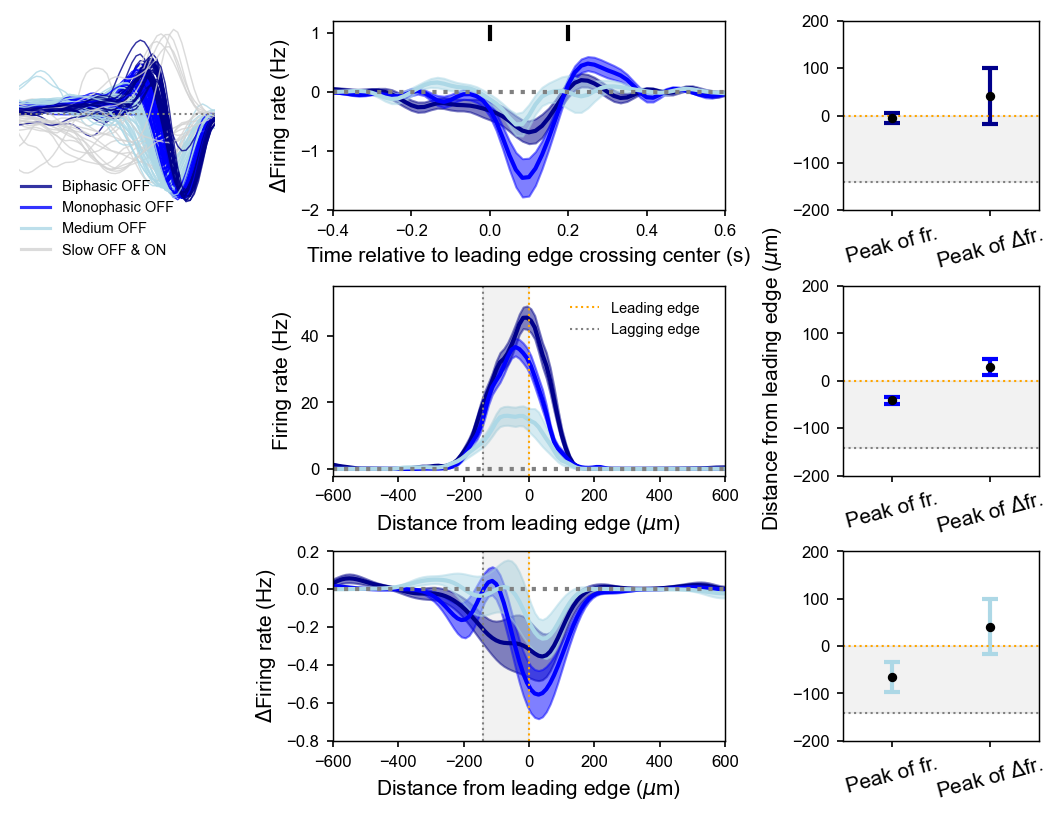

In [29]:
fig = plt.figure(figsize=(8.5, 6))
plt.text(0.73, 0.5, 'Distance from leading edge ($\mu$m)', verticalalignment='center', horizontalalignment='center', rotation=90, fontsize=10)
plt.axis('off')
gs = fig.add_gridspec(3, 3, width_ratios=(1, 2, 1), height_ratios=(1, 1, 1), 
                      left=0.1, right=0.9, bottom=0.1, top=0.9, 
                      wspace=0.45, hspace=0.4)

ax1 = fig.add_subplot(gs[0, 0])
for g in range(N_g):
    if df['g_classify_idx'][g] == 0:
        ax1.plot(np.linspace(-0.5, 0, 60), ex.rf['g']['time'][g], linewidth=0.7, color='darkblue', alpha=0.8)
    if df['g_classify_idx'][g] == 4:
        ax1.plot(np.linspace(-0.5, 0, 60), ex.rf['g']['time'][g], linewidth=0.7, color='blue', alpha=0.8)
    if df['g_classify_idx'][g] == 1:
        ax1.plot(np.linspace(-0.5, 0, 60), ex.rf['g']['time'][g], linewidth=0.7, color='lightblue', alpha=0.8)
    if df['g_classify_idx'][g] in [2, 3, 5, 6, 7]:
        ax1.plot(np.linspace(-0.5, 0, 60), ex.rf['g']['time'][g], linewidth=0.7, color='lightgray', alpha=0.8)
ax1.axhline(0, color='gray', linestyle=':', linewidth=1)
ax1.set_xlim([-0.4, 0])
ax1.axis('off')
ax1.legend(['Biphasic OFF', 'Monophasic OFF', 'Medium OFF', 'Slow OFF & ON'], bbox_to_anchor=(-0.02, -0.28), loc='lower left', borderaxespad=0, frameon=False, framealpha=0, fontsize=7)
leg1 = ax1.get_legend()
leg1.legendHandles[0].set_color('darkblue')
leg1.legendHandles[1].set_color('blue')
leg1.legendHandles[2].set_color('lightblue')
leg1.legendHandles[3].set_color('lightgray')
leg1.legendHandles[0].set_linewidth(1.5)
leg1.legendHandles[1].set_linewidth(1.5)
leg1.legendHandles[2].set_linewidth(1.5)
leg1.legendHandles[3].set_linewidth(1.5)

ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(tbins, smooth_1d(np.nanmean(re1['sample']['gmtr']['c']['all']['diff'], 1), sm_sigma_t), color='darkblue', linewidth=2)
ax2.plot(tbins, smooth_1d(np.nanmean(re2['sample']['gmtr']['c']['all']['diff'], 1), sm_sigma_t), color='blue', linewidth=2)
ax2.plot(tbins, smooth_1d(np.nanmean(re3['sample']['gmtr']['c']['all']['diff'], 1), sm_sigma_t), color='lightblue', linewidth=2)
ax2.fill_between(tbins, 
                 smooth_1d(np.nanmean(re1['sample']['gmtr']['c']['all']['diff'], 1), sm_sigma_t) - fast_off_time_se,                  
                 smooth_1d(np.nanmean(re1['sample']['gmtr']['c']['all']['diff'], 1), sm_sigma_t) + fast_off_time_se,
                 color='darkblue', alpha=0.5)
ax2.fill_between(tbins, 
                 smooth_1d(np.nanmean(re2['sample']['gmtr']['c']['all']['diff'], 1), sm_sigma_t) - medium_off_time_se, 
                 smooth_1d(np.nanmean(re2['sample']['gmtr']['c']['all']['diff'], 1), sm_sigma_t) + medium_off_time_se,
                 color='blue', alpha=0.5)
ax2.fill_between(tbins, 
                 smooth_1d(np.nanmean(re3['sample']['gmtr']['c']['all']['diff'], 1), sm_sigma_t) - slow_off_time_se, 
                 smooth_1d(np.nanmean(re3['sample']['gmtr']['c']['all']['diff'], 1), sm_sigma_t) + slow_off_time_se,
                 color='lightblue', alpha=0.5)
ax2.axhline(0, color='gray', linestyle=':', linewidth=2)
ax2.plot([0, 0], [0.9, 1.1], color='black', linewidth=2)
ax2.plot([0.2, 0.2], [0.9, 1.1], color='black' ,linewidth=2)
ax2.set_xlim([-0.4, 0.6])
ax2.set_ylim([-2, 1.2])
ax2.set_xlabel('Time relative to leading edge crossing center (s)', fontsize=10)
ax2.set_ylabel('$\Delta$Firing rate (Hz)', fontsize=10)

ax3 = fig.add_subplot(gs[1, 1])
ax3.plot(sbins, smooth_1d(np.nanmean(re1['sample']['gmtr']['c']['all']['con'], 0), 1), color='darkblue', linewidth=2)
ax3.plot(sbins, smooth_1d(np.nanmean(re2['sample']['gmtr']['c']['all']['con'], 0), 1), color='blue', linewidth=2)
ax3.plot(sbins, smooth_1d(np.nanmean(re3['sample']['gmtr']['c']['all']['con'], 0), 1), color='lightblue', linewidth=2)
ax3.fill_between(sbins, 
                 smooth_1d(np.nanmean(re1['sample']['gmtr']['c']['all']['con'], 0), 1) - fast_off_space_se, 
                 smooth_1d(np.nanmean(re1['sample']['gmtr']['c']['all']['con'], 0), 1) + fast_off_space_se,
                 color='darkblue', alpha=0.5)
ax3.fill_between(sbins, 
                 smooth_1d(np.nanmean(re2['sample']['gmtr']['c']['all']['con'], 0), 1) - medium_off_space_se, 
                 smooth_1d(np.nanmean(re2['sample']['gmtr']['c']['all']['con'], 0), 1) + medium_off_space_se,
                 color='blue', alpha=0.5)
ax3.fill_between(sbins, 
                 smooth_1d(np.nanmean(re3['sample']['gmtr']['c']['all']['con'], 0), 1) - slow_off_space_se, 
                 smooth_1d(np.nanmean(re3['sample']['gmtr']['c']['all']['con'], 0), 1) + slow_off_space_se,
                 color='lightblue', alpha=0.5)
ax3.axhline(0, color='gray', linestyle=':', linewidth=2)
ax3.fill_between(np.linspace(-(100/17) * 24, 0, 100), y1=100 * [-2], y2=100 * [55], color='gray', alpha=0.1)
ax3.axvline(-(100/17) * 24, color='gray', linestyle=':', linewidth=1)
ax3.axvline(0, color='orange', linestyle=':', linewidth=1)
ax3.set_xlim([-600, 600])
ax3.set_ylim([-2, 55])
ax3.set_xlabel('Distance from leading edge ($\mu$m)', fontsize=10)
ax3.set_ylabel('Firing rate (Hz)', fontsize=10)

ax3.legend(['Leading edge', 'Lagging edge'], bbox_to_anchor=(0.95, 0.95), loc='upper right', borderaxespad=0, frameon=False, framealpha=0, fontsize=7)
leg3 = ax3.get_legend()
leg3.legendHandles[0].set_color('orange')
leg3.legendHandles[1].set_color('gray')
leg3.legendHandles[0].set_linestyle(':')
leg3.legendHandles[1].set_linestyle(':')
leg3.legendHandles[0].set_linewidth(1)
leg3.legendHandles[1].set_linewidth(1)

ax4 = fig.add_subplot(gs[2, 1])
ax4.plot(sbins, smooth_1d(np.nanmean(re1['sample']['gmtr']['c']['all']['diff'], 0), sm_sigma_s), color='darkblue', linewidth=2)
ax4.plot(sbins, smooth_1d(np.nanmean(re2['sample']['gmtr']['c']['all']['diff'], 0), sm_sigma_s), color='blue', linewidth=2)
ax4.plot(sbins, smooth_1d(np.nanmean(re3['sample']['gmtr']['c']['all']['diff'], 0), sm_sigma_s), color='lightblue', linewidth=2)
ax4.fill_between(sbins, 
                 smooth_1d(np.nanmean(re1['sample']['gmtr']['c']['all']['diff'], 0), sm_sigma_s) - fast_off_diff_space_se, 
                 smooth_1d(np.nanmean(re1['sample']['gmtr']['c']['all']['diff'], 0), sm_sigma_s) + fast_off_diff_space_se,
                 color='darkblue', alpha=0.5)
ax4.fill_between(sbins, 
                 smooth_1d(np.nanmean(re2['sample']['gmtr']['c']['all']['diff'], 0), sm_sigma_s) - medium_off_diff_space_se, 
                 smooth_1d(np.nanmean(re2['sample']['gmtr']['c']['all']['diff'], 0), sm_sigma_s) + medium_off_diff_space_se,
                 color='blue', alpha=0.5)
ax4.fill_between(sbins, 
                 smooth_1d(np.nanmean(re3['sample']['gmtr']['c']['all']['diff'], 0), sm_sigma_s) - slow_off_diff_space_se, 
                 smooth_1d(np.nanmean(re3['sample']['gmtr']['c']['all']['diff'], 0), sm_sigma_s) + slow_off_diff_space_se,
                 color='lightblue', alpha=0.5)
ax4.axhline(0, color='gray', linestyle=':', linewidth=2)
ax4.fill_between(np.linspace(-(100/17) * 24, 0, 100), y1=100 * [-0.8], y2=100 * [0.2], color='gray', alpha=0.1)
ax4.axvline(-(100/17) * 24, color='gray', linestyle=':', linewidth=1)
ax4.axvline(0, color='orange', linestyle=':', linewidth=1)
ax4.set_xlim([-600, 600])
ax4.set_ylim([-0.8, 0.2])
ax4.set_xlabel('Distance from leading edge ($\mu$m)', fontsize=10)
ax4.set_ylabel('$\Delta$Firing rate (Hz)', fontsize=10)

ax5 = fig.add_subplot(gs[0, 2])
ax5.fill_between(np.linspace(-1, 2, 100), y1=100 * [-(100/17) * 24], y2=100 * [0], color='gray', alpha=0.1)
ax5.errorbar(0, sbins[np.argmax(smooth_1d(np.nanmean(re1['sample']['gmtr']['c']['all']['con'], 0), 1))], yerr=fast_off_peak_space_se, fmt='k.', markersize=5, mew=2, ecolor='darkblue', elinewidth=2, capsize=4)
ax5.errorbar(1, sbins[np.argmin(smooth_1d(np.nanmean(re1['sample']['gmtr']['c']['all']['diff'], 0), sm_sigma_s))], yerr=fast_off_diff_peak_space_se, fmt='k.', markersize=5, mew=2, ecolor='darkblue', elinewidth=2, capsize=4)
ax5.axhline(0, color='orange', linestyle=':', linewidth=1)
ax5.axhline(-24 * (100/17), color='gray', linestyle=':', linewidth=1)
ax5.set_xlim((-0.5, 1.5))
ax5.set_ylim((-200, 200))
ax5.set_xticks([0, 1])
ax5.set_xticklabels(['Peak of fr.', 'Peak of $\Delta$fr.'], fontsize=10, rotation=15)

ax6 = fig.add_subplot(gs[1, 2])
ax6.fill_between(np.linspace(-1, 2, 100), y1=100 * [-(100/17) * 24], y2=100 * [0], color='gray', alpha=0.1)
ax6.errorbar(0, sbins[np.argmax(smooth_1d(np.nanmean(re2['sample']['gmtr']['c']['all']['con'], 0), 1))], yerr=medium_off_peak_space_se, fmt='k.', markersize=5, mew=2, ecolor='blue', elinewidth=2, capsize=4)
ax6.errorbar(1, sbins[np.argmin(smooth_1d(np.nanmean(re2['sample']['gmtr']['c']['all']['diff'], 0), sm_sigma_s))], yerr=medium_off_diff_peak_space_se, fmt='k.', markersize=5, mew=2, ecolor='blue', elinewidth=2, capsize=4)
ax6.axhline(0, color='orange', linestyle=':', linewidth=1)
ax6.axhline(-24 * (100/17), color='gray', linestyle=':', linewidth=1)
ax6.set_xlim((-0.5, 1.5))
ax6.set_ylim((-200, 200))
ax6.set_xticks([0, 1])
ax6.set_xticklabels(['Peak of fr.', 'Peak of $\Delta$fr.'], fontsize=10, rotation=15)

ax7 = fig.add_subplot(gs[2, 2])
ax7.fill_between(np.linspace(-1, 2, 100), y1=100 * [-(100/17) * 24], y2=100 * [0], color='gray', alpha=0.1)
ax7.errorbar(0, sbins[np.argmax(smooth_1d(np.nanmean(re3['sample']['gmtr']['c']['all']['con'], 0), 1))], yerr=slow_off_peak_space_se, fmt='k.', markersize=5, mew=2, ecolor='lightblue', elinewidth=2, capsize=4)
ax7.errorbar(1, sbins[np.argmin(smooth_1d(np.nanmean(re3['sample']['gmtr']['c']['all']['diff'], 0), sm_sigma_s))], yerr=slow_off_diff_peak_space_se, fmt='k.', markersize=5, mew=2, ecolor='lightblue', elinewidth=2, capsize=4)
ax7.axhline(0, color='orange', linestyle=':', linewidth=1)
ax7.axhline(-24 * (100/17), color='gray', linestyle=':', linewidth=1)
ax7.set_xlim((-0.5, 1.5))
ax7.set_ylim((-200, 200))
ax7.set_xticks([0, 1])
ax7.set_xticklabels(['Peak of fr.', 'Peak of $\Delta$fr.'], fontsize=10, rotation=15)

#plt.savefig('fig_c03+c04+c05_all+delta+fr+peak.pdf', bbox_inches='tight', transparent=True, dpi=300)

In [ ]:
#--------------------------------------------------------------------

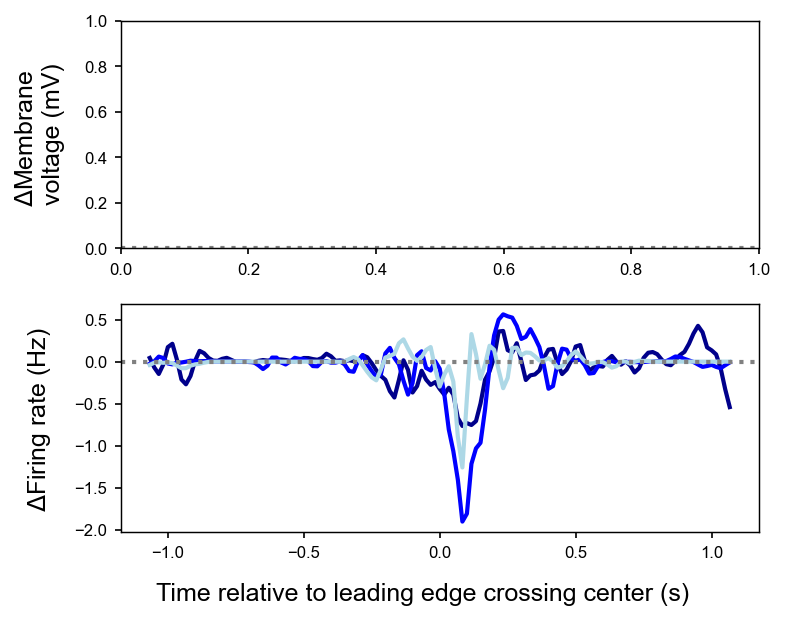

In [98]:
fig = plt.figure(figsize=(5, 4))

fig.text(0.5, -0.01, 'Time relative to leading edge crossing center (s)', verticalalignment='center', horizontalalignment='center')
fig.text(-0.01, 0.75, '$\Delta$Membrane \n voltage (mV)', verticalalignment='center', horizontalalignment='center', rotation=90)
fig.text(-0.01, 0.28, '$\Delta$Firing rate (Hz)', verticalalignment='center', horizontalalignment='center', rotation=90)

ax1 = plt.subplot(211)
#ax1.plot(tbins, np.nanmean(ex.i_a['mb_baseline0_cen_i'][df.iloc[re1['attrs']['g_list']]['exp_id'].unique()], (0, 1, 2, 3)), 'darkblue', linewidth=2)
#ax1.plot(tbins, np.nanmean(ex.i_a['mb_baseline0_cen_i'][df.iloc[re2['attrs']['g_list']]['exp_id'].unique()], (0, 1, 2, 3)), 'lightblue', linewidth=2)
ax1.axhline(0, color='gray', linestyle=':', linewidth=2)
#ax1.set_xlim(-0.3, 0.6)

ax2 = plt.subplot(212)
ax2.plot(tbins, smooth_1d(np.nanmean(re1['sample']['gmtr']['c']['all']['diff'], 1), sm_sigma_t), color='darkblue', linewidth=2)
ax2.plot(tbins, smooth_1d(np.nanmean(re2['sample']['gmtr']['c']['all']['diff'], 1), sm_sigma_t), color='blue', linewidth=2)
ax2.plot(tbins, smooth_1d(np.nanmean(re3['sample']['gmtr']['c']['all']['diff'], 1), sm_sigma_t), color='lightblue', linewidth=2)

ax2.axhline(0, color='gray', linestyle=':', linewidth=2)
#ax2.set_xlim(-0.3, 0.6)

plt.tight_layout()
#plt.savefig('fig_c03+c04_delta+fr+time', bbox_inches='tight', dpi=300)

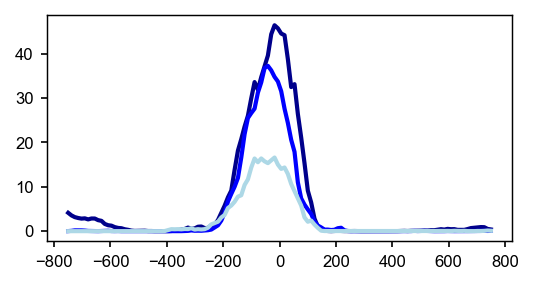

In [146]:
plt.plot(sbins, smooth_1d(np.nanmean(re1['sample']['gmtr']['c']['all']['con'], 0), 0.5), color='darkblue', linewidth=2)
plt.plot(sbins, smooth_1d(np.nanmean(re2['sample']['gmtr']['c']['all']['con'], 0), 0.5), color='blue', linewidth=2)
plt.plot(sbins, smooth_1d(np.nanmean(re3['sample']['gmtr']['c']['all']['con'], 0), 0.5), color='lightblue', linewidth=2)

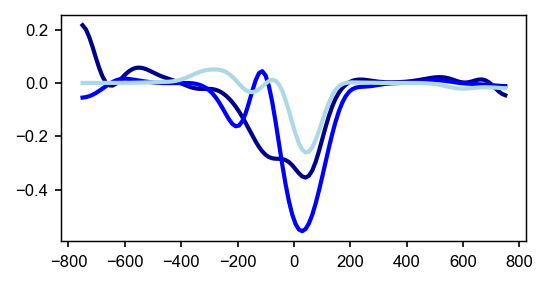

In [147]:
plt.plot(sbins, smooth_1d(np.nanmean(re1['sample']['gmtr']['c']['all']['diff'], 0), sm_sigma_s+1), color='darkblue', linewidth=2)
plt.plot(sbins, smooth_1d(np.nanmean(re2['sample']['gmtr']['c']['all']['diff'], 0), sm_sigma_s+1), color='blue', linewidth=2)
plt.plot(sbins, smooth_1d(np.nanmean(re3['sample']['gmtr']['c']['all']['diff'], 0), sm_sigma_s+1), color='lightblue', linewidth=2)

In [22]:
sm_sigma_s = 4
sm_sigma_t = 2
#peak_con_1_s = np.stack([np.argmax(np.nanmean(re['bs'][n]['gmtr']['c']['1']['con'], 0)) for n in range(N)])
#peak_con_2_s = np.stack([np.argmax(np.nanmean(re['bs'][n]['gmtr']['c']['2']['con'], 0)) for n in range(N)])
#peak_con_4_s = np.stack([np.argmax(np.nanmean(re['bs'][n]['gmtr']['c']['4']['con'], 0)) for n in range(N)])
peak_con_all_s = np.stack([np.argmax(np.nanmean(re1['bs'][n]['gmtr']['c']['all']['con'], 0)) for n in range(N)])
#peak_diff_1_s = np.stack([np.argmin(smooth_1d(np.nanmean(re['bs'][n]['gmtr']['c']['1']['diff'], 0), sm_sigma_s)) for n in range(N)])
#peak_diff_2_s = np.stack([np.argmin(smooth_1d(np.nanmean(re['bs'][n]['gmtr']['c']['2']['diff'], 0), sm_sigma_s)) for n in range(N)])
#peak_diff_4_s = np.stack([np.argmin(smooth_1d(np.nanmean(re['bs'][n]['gmtr']['c']['4']['diff'], 0), sm_sigma_s)) for n in range(N)])
peak_diff_all_s = np.stack([np.argmin(smooth_1d(np.nanmean(re1['bs'][n]['gmtr']['c']['all']['diff'], 0), sm_sigma_s)) for n in range(N)])
#peak_diff_1_t = np.stack([np.argmin(smooth_1d(np.nanmean(re['bs'][n]['gmtr']['c']['1']['diff'], 1), sm_sigma_t)) for n in range(N)])
#peak_diff_2_t = np.stack([np.argmin(smooth_1d(np.nanmean(re['bs'][n]['gmtr']['c']['2']['diff'], 1), sm_sigma_t)) for n in range(N)])
#peak_diff_4_t = np.stack([np.argmin(smooth_1d(np.nanmean(re['bs'][n]['gmtr']['c']['4']['diff'], 1), sm_sigma_t)) for n in range(N)])
peak_diff_all_t = np.stack([np.argmin(smooth_1d(np.nanmean(re1['bs'][n]['gmtr']['c']['all']['diff'], 1), sm_sigma_t)) for n in range(N)])

In [25]:
peak2_con_all_s = np.stack([np.argmax(np.nanmean(re2['bs'][n]['gmtr']['c']['all']['con'], 0)) for n in range(N)])
peak2_diff_all_s = np.stack([np.argmin(smooth_1d(np.nanmean(re2['bs'][n]['gmtr']['c']['all']['diff'], 0), sm_sigma_s)) for n in range(N)])
peak2_diff_all_t = np.stack([np.argmin(smooth_1d(np.nanmean(re2['bs'][n]['gmtr']['c']['all']['diff'], 1), sm_sigma_t)) for n in range(N)])

In [26]:
#com_con_1_s = np.stack([scipy.ndimage.center_of_mass(np.nanmean(re['bs'][n]['gmtr']['c']['1']['con'], 0))[0] for n in range(N)])
#com_con_2_s = np.stack([scipy.ndimage.center_of_mass(np.nanmean(re['bs'][n]['gmtr']['c']['2']['con'], 0))[0] for n in range(N)])
#com_con_4_s = np.stack([scipy.ndimage.center_of_mass(np.nanmean(re['bs'][n]['gmtr']['c']['4']['con'], 0))[0] for n in range(N)])
com_con_all_s = np.stack([scipy.ndimage.center_of_mass(np.nanmean(re1['bs'][n]['gmtr']['c']['all']['con'], 0))[0] for n in range(N)])
#com_diff_1_s = np.stack([scipy.ndimage.center_of_mass(smooth_1d(np.nanmean(re['bs'][n]['gmtr']['c']['1']['diff'], 0), sm_sigma_s))[0] for n in range(N)])
#com_diff_2_s = np.stack([scipy.ndimage.center_of_mass(smooth_1d(np.nanmean(re['bs'][n]['gmtr']['c']['2']['diff'], 0), sm_sigma_s))[0] for n in range(N)])
#com_diff_4_s = np.stack([scipy.ndimage.center_of_mass(smooth_1d(np.nanmean(re['bs'][n]['gmtr']['c']['4']['diff'], 0), sm_sigma_s))[0] for n in range(N)])
com_diff_all_s = np.stack([scipy.ndimage.center_of_mass(smooth_1d(np.nanmean(re1['bs'][n]['gmtr']['c']['all']['diff'], 0), sm_sigma_s))[0] for n in range(N)])

In [27]:
com_diff_all_t = com_diff_all_s = np.stack([scipy.ndimage.center_of_mass(smooth_1d(np.nanmean(re1['bs'][n]['gmtr']['c']['all']['diff'], 1), sm_sigma_t))[0] for n in range(N)])

In [28]:
com2_con_all_s = np.stack([scipy.ndimage.center_of_mass(np.nanmean(re2['bs'][n]['gmtr']['c']['all']['con'], 0))[0] for n in range(N)])
com2_diff_all_s = np.stack([scipy.ndimage.center_of_mass(smooth_1d(np.nanmean(re2['bs'][n]['gmtr']['c']['all']['diff'], 0), sm_sigma_s))[0] for n in range(N)])
com2_diff_all_t = np.stack([scipy.ndimage.center_of_mass(smooth_1d(np.nanmean(re2['bs'][n]['gmtr']['c']['all']['diff'], 1), sm_sigma_t))[0] for n in range(N)])

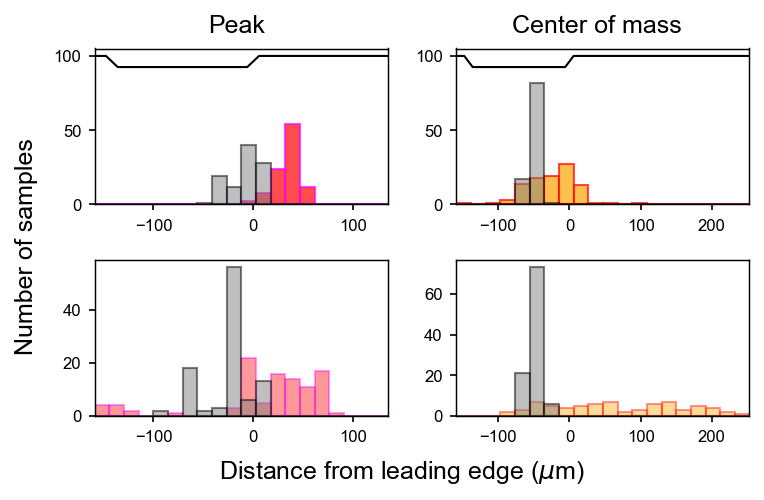

In [112]:
slim1 = (i2s(50), i2s(75))
slim2 = (i2s(50), i2s(85))

fig = plt.figure(figsize=(5, 3))

fig.text(0.5, 0, 'Distance from leading edge ($\mu$m)', verticalalignment='center', horizontalalignment='center')
fig.text(0, 0.5, 'Number of samples', verticalalignment='center', horizontalalignment='center', rotation=90)
fig.text(0.28, 0.99, 'Peak', verticalalignment='center', horizontalalignment='center')
fig.text(0.76, 0.99, 'Center of mass', verticalalignment='center', horizontalalignment='center')

ax1 = plt.subplot(221)
ax1.plot(sbins, np.nanmean(tr(bar_st), 0)*15 + 100, 'k')
ax1.hist(i2s(peak_diff_all_s), 20, slim1, color='red', edgecolor='magenta', alpha=0.7)
ax1.hist(i2s(peak_con_all_s), 20, slim1, color='gray', edgecolor='k', alpha=0.5)
ax1.set_xlim(slim1)

ax2 = plt.subplot(222)
ax2.plot(sbins, np.nanmean(tr(bar_st), 0)*15 + 100, 'k')
ax2.hist(i2s(com_diff_all_s), 20, slim2, color='orange', edgecolor='red', alpha=0.7)
ax2.hist(i2s(com_con_all_s), 20, slim2, color='gray', edgecolor='k', alpha=0.5)
ax2.set_xlim(slim2)

ax3 = plt.subplot(223)
ax3.hist(i2s(peak2_diff_all_s), 20, slim1, color='red', edgecolor='magenta', alpha=0.4)
ax3.hist(i2s(peak2_con_all_s), 20, slim1, color='gray', edgecolor='k', alpha=0.5)
ax3.set_xlim(slim1)

ax4 = plt.subplot(224)
ax4.hist(i2s(com2_diff_all_s), 20, slim2, color='orange', edgecolor='red', alpha=0.4)
ax4.hist(i2s(com2_con_all_s), 20, slim2, color='gray', edgecolor='k', alpha=0.5)
ax4.set_xlim(slim2)

plt.tight_layout()
#plt.savefig('fig_c03+c04_peak+com+histogram', bbox_inches='tight', dpi=300)

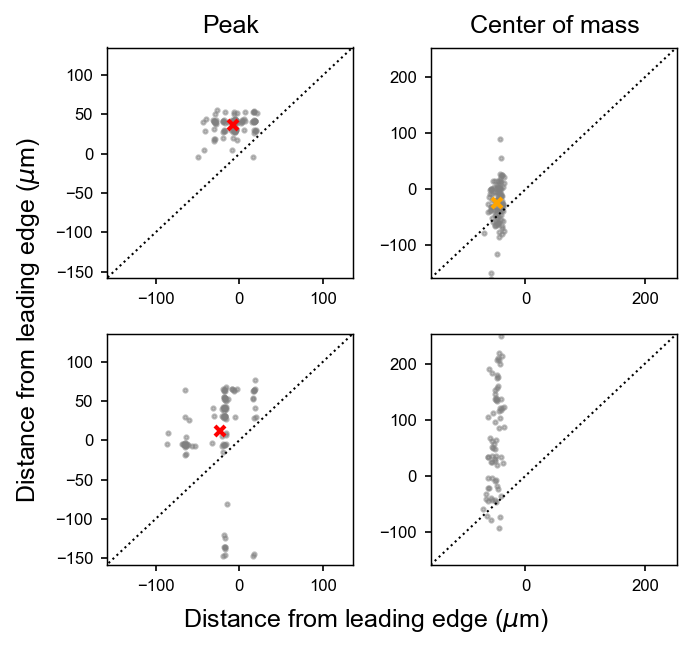

In [113]:
fig = plt.figure(figsize=(4.5, 4))

fig.text(0.5, 0, 'Distance from leading edge ($\mu$m)', verticalalignment='center', horizontalalignment='center')
fig.text(0, 0.5, 'Distance from leading edge ($\mu$m)', verticalalignment='center', horizontalalignment='center', rotation=90)
fig.text(0.3, 0.99, 'Peak', verticalalignment='center', horizontalalignment='center')
fig.text(0.78, 0.99, 'Center of mass', verticalalignment='center', horizontalalignment='center')

ax1 = plt.subplot(221)
ax1.plot(i2s(peak_con_all_s)+np.random.normal(0, 1.5, re1['attrs']['N']), i2s(peak_diff_all_s)+np.random.normal(0, 1.5, re1['attrs']['N']), 
        color='gray', linestyle='', marker='o', markersize=2, alpha=0.5)
ax1.plot(np.mean(i2s(peak_con_all_s)), np.mean(i2s(peak_diff_all_s)), 
        color='red', linestyle='', marker='x', markersize=5, mew=2)
ax1.plot(np.arange(-300, 400), np.arange(-300, 400), 'k:')
ax1.set_xlim(slim1)
ax1.set_ylim(slim1)

ax2 = plt.subplot(222)
ax2.plot(i2s(com_con_all_s), i2s(com_diff_all_s), 
        color='gray', linestyle='', marker='o', markersize=2, alpha=0.5)
ax2.plot(np.mean(i2s(com_con_all_s)), np.mean(i2s(com_diff_all_s)), 
         color='orange', linestyle='', marker='x', markersize=5, mew=2)
ax2.plot(np.arange(-300, 400), np.arange(-300, 400), 'k:')
ax2.set_xlim(slim2)
ax2.set_ylim(slim2)

ax3 = plt.subplot(223)
ax3.plot(i2s(peak2_con_all_s)+np.random.normal(0, 1.5, re2['attrs']['N']), i2s(peak2_diff_all_s)+np.random.normal(0, 1.5, re2['attrs']['N']), 
        color='gray', linestyle='', marker='o', markersize=2, alpha=0.5)
ax3.plot(np.mean(i2s(peak2_con_all_s)), np.mean(i2s(peak2_diff_all_s)), 
        color='red', linestyle='', marker='x', markersize=5, mew=2)
ax3.plot(np.arange(-300, 400), np.arange(-300, 400), 'k:')
ax3.set_xlim(slim1)
ax3.set_ylim(slim1)

ax4 = plt.subplot(224)
ax4.plot(i2s(com2_con_all_s), i2s(com2_diff_all_s), 
        color='gray', linestyle='', marker='o', markersize=2, alpha=0.5)
ax4.plot(np.mean(i2s(com2_con_all_s)), np.mean(i2s(com2_diff_all_s)), 
         color='orange', linestyle='', marker='x', markersize=5, mew=2)
ax4.plot(np.arange(-300, 400), np.arange(-300, 400), 'k:')
ax4.set_xlim(slim2)
ax4.set_ylim(slim2)

plt.tight_layout()
#plt.savefig('fig_c03+c04_peak+com+scatter', bbox_inches='tight', dpi=300)

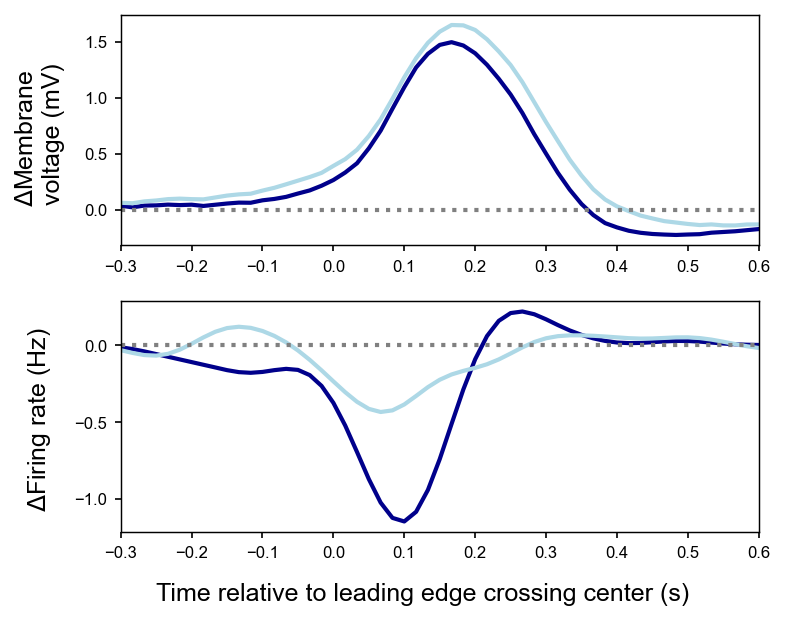

In [127]:
fig = plt.figure(figsize=(5, 4))

fig.text(0.5, -0.01, 'Time relative to leading edge crossing center (s)', verticalalignment='center', horizontalalignment='center')
fig.text(-0.01, 0.75, '$\Delta$Membrane \n voltage (mV)', verticalalignment='center', horizontalalignment='center', rotation=90)
fig.text(-0.01, 0.28, '$\Delta$Firing rate (Hz)', verticalalignment='center', horizontalalignment='center', rotation=90)

ax1 = plt.subplot(211)
ax1.plot(tbins, np.nanmean(ex.i_a['mb_baseline0_cen_i'][df.iloc[re1['attrs']['g_list']]['exp_id'].unique()], (0, 1, 2, 3)), 'darkblue', linewidth=2)
ax1.plot(tbins, np.nanmean(ex.i_a['mb_baseline0_cen_i'][df.iloc[re2['attrs']['g_list']]['exp_id'].unique()], (0, 1, 2, 3)), 'lightblue', linewidth=2)
ax1.axhline(0, color='gray', linestyle=':', linewidth=2)
ax1.set_xlim(-0.3, 0.6)

ax2 = plt.subplot(212)
ax2.plot(tbins, smooth_1d(np.nanmean(re1['sample']['gm']['c']['all']['diff'], 1), sm_sigma_t), color='darkblue', linewidth=2)
ax2.plot(tbins, smooth_1d(np.nanmean(re2['sample']['gm']['c']['all']['diff'], 1), sm_sigma_t), color='lightblue', linewidth=2)
ax2.axhline(0, color='gray', linestyle=':', linewidth=2)
ax2.set_xlim(-0.3, 0.6)

plt.tight_layout()
#plt.savefig('fig_c03+c04_delta+fr+time', bbox_inches='tight', dpi=300)

In [199]:
li = 'all'
m_raw = re['sample']['gmtr']['c'][li]['diff']
m_raw_st = re['sample']['gm']['c'][li]['diff']
m_smooth = smooth(nn(m_raw), sm_sigma_t, sm_sigma_s)
m_smooth_st = smooth(nn(m_raw_st), sm_sigma_t, sm_sigma_s)
m_s = smooth_1d(np.nanmean(m_raw, 0), sm_sigma_s)
m_t = smooth_1d(np.nanmean(m_raw, 1), sm_sigma_t)

ma_s = smooth_1d(np.nanmean(smooth(nn(re['sample']['gmtr']['c'][li]['amp_con']), sm_sigma_t, sm_sigma_s), 0), sm_sigma_s)
md_s = smooth_1d(np.nanmean(smooth(nn(re['sample']['gmtr']['c'][li]['dim_con']), sm_sigma_t, sm_sigma_s), 0), sm_sigma_s)

mg_raw_st = re['sample']['gm']['c'][li]['con']
mg_raw = re['sample']['gmtr']['c'][li]['con']
mg_s = np.nanmean(mg_raw, 0)
b = tr(bar_st)
extent = (-128*(100/17), 128*(100/17), 129*(1/60)/2, -129*(1/60)/2)
extent2 = (-129*(1/60)/2, 129*(1/60)/2, -128*(100/17), 128*(100/17))

## 

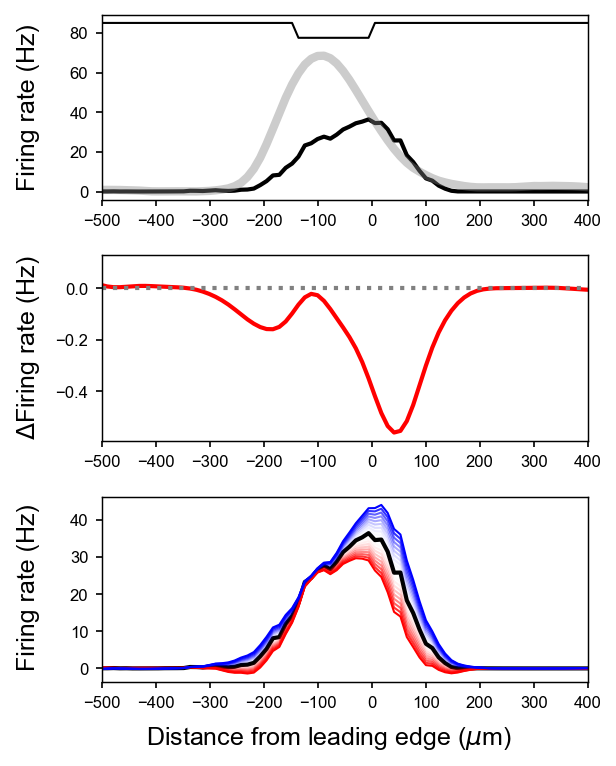

In [202]:
gain_a = np.linspace(1, 20, 10)
gain_d = np.linspace(-1, -20, 10)

fig = plt.figure(figsize=(4, 5))

fig.text(0.5, 0, 'Distance from leading edge ($\mu$m)', verticalalignment='center', horizontalalignment='center')
fig.text(0, 0.84, 'Firing rate (Hz)', verticalalignment='center', horizontalalignment='center', rotation=90)
fig.text(0, 0.52, '$\Delta$Firing rate (Hz)', verticalalignment='center', horizontalalignment='center', rotation=90)
fig.text(0, 0.20, 'Firing rate (Hz)', verticalalignment='center', horizontalalignment='center', rotation=90)

ax1 = plt.subplot(311)
ax1.plot(sbins, mg_s, 'k', linewidth=2)
ax1.plot(sbins, np.nanmean(tr(bar_st), 0)*15 + 85, 'k')
ax1.plot(sbins, np.nanmean(re['sample']['gmtr']['c']['ln']['con'], 0), color='gray', linewidth=4, linestyle='-', alpha=0.4)
ax1.set_xlim((-500, 400))

ax2 = plt.subplot(312)
ax2.plot(sbins, m_s, 'r', linewidth=2)
ax2.axhline(0, color='gray', linestyle=':', linewidth=2)
ax2.set_xlim((-500, 400))

ax3 = plt.subplot(313)
ax3.plot(sbins, mg_s, 'k', linewidth=2)
for i, g in enumerate(gain_a):
    ax3.plot(sbins, smooth_1d(mg_s + gain_a[i] * m_s, 0.5), 'r', linewidth=1, alpha=(abs(g)/np.max(abs(gain_a)))**2)
for i, g in enumerate(gain_d):
    ax3.plot(sbins, smooth_1d(mg_s + gain_d[i] * m_s, 0.5), 'b', linewidth=1, alpha=(abs(g)/np.max(abs(gain_d)))**2)
ax3.set_xlim((-500, 400))

plt.tight_layout()
#plt.savefig('fig_c01_2+delta+fr+space+model', bbox_inches='tight', dpi=300)